In [1]:
import torch
from torch.utils.data import DataLoader
from dataset import YoloDarknetDataset
from model import model_builder
import lightnet as ln
from test_script import test_step
from utils import RGBDCustomTransform, RGBCustomTransform, DepthCustomTransform, show_sample, DepthCustomTransform, load_config, plot_result
from debug_training import debug_training_sample, debug_training_sample_extra
import matplotlib.pyplot as plt

/home/gkmo/workspace/rgbd-yolov2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = load_config("new_configs/new_distill_depth_100.yaml")
#config = load_config("configs/depth_100_epochs.yaml")


OUTPUT_DIR = config["output_dir"]
TRAIN_IMG_DIR = config["train_img_dir"]
TRAIN_DEPTH_DIR = config["train_depth_dir"]
TRAIN_LABEL_DIR =  config["train_label_dir"]
VAL_IMG_DIR = config["val_img_dir"]
VAL_DEPTH_DIR = config["val_depth_dir"]
VAL_LABEL_DIR =  config["val_label_dir"]
TEST_IMG_DIR = config["test_img_dir"]
TEST_DEPTH_DIR = config["test_depth_dir"]
TEST_LABEL_DIR =  config["test_label_dir"]
BATCH_SIZE = config["batch_size"]
NUM_WORKERS = config["num_workers"]
LEARNING_RATE = config["learning_rate"]
LR_DECAY = config["lr_decay"]
NUM_EPOCHS = config["num_epochs"]
MODEL_TYPE = config["model_type"]
FUSE_LAYER = config["fuse_layer"]
EXPERIMENT_NAME = config["experiment_name"]
VAL_EVERY = config["val_every"]
NORMALIZATION = config["normalization"]
DEPTH_CHECKPOINT = config["depth_checkpoint"]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3


In [95]:
from PIL import ImageDraw

def draw_gt_boxes_on_image(image, label_path, color="red", class_names=None):
    """
    Draws ground truth bounding boxes from a label file on a PIL image and displays it.
    Args:
        image: PIL.Image object
        label_path: path to label txt file (format: class x_center y_center width height, normalized)
        color: box color
        class_names: list of class names (optional)
    """
    draw = ImageDraw.Draw(image)
    img_w, img_h = image.size

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x, y, w, h = map(float, parts)
            # Convert from normalized center format to pixel coordinates
            x_center = x * img_w
            y_center = y * img_h
            box_w = w * img_w
            box_h = h * img_h
            left = x_center - box_w / 2
            top = y_center - box_h / 2
            right = x_center + box_w / 2
            bottom = y_center + box_h / 2
            draw.rectangle([left, top, right, bottom], outline=color, width=2)
            if class_names:
                draw.text((left, top), class_names[int(cls)], fill=color)
            else:
                draw.text((left, top), str(int(cls)), fill=color)
    return image

In [3]:
model = model_builder(num_classes=NUM_CLASSES, model_type=MODEL_TYPE, fuse_layer=FUSE_LAYER)
model.load("output/distill_any2_rgbd_100_epochs/distill_any_rgbd_100_epochs_best.pth")
model.to(DEVICE)

# train_transforms = RGBDCustomTransform(resize_size=(416, 416), flip_prob=0.5)
# test_transforms = RGBDCustomTransform(resize_size=(416, 416), flip_prob=0)

All RGB weights are equivalent.

All Depth weights are equivalent.


/home/gkmo/workspace/rgbd-yolov2/.venv/lib/python3.10/site-packages/lightnet/network/module/_lightnet.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.loa

YoloFusion(
  (layers): ModuleList(
    (0): ModuleDict(
      (1_convbatch_regular): Conv2dBatchAct(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (1_convbatch_fusion): Conv2dBatchAct(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
    )
    (1): FusionSequential(
      (Regular & Fusion): Sequential(
        (2_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3_convbatch): Conv2dBatchAct(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
        (4_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5_convbatch): Conv2dBatchAct(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
        (6_convbatch): Conv2dBatchAct(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), LeakyReLU(ne

In [4]:
# model = model_builder(num_classes=NUM_CLASSES, model_type=MODEL_TYPE, fuse_layer=FUSE_LAYER)
# model.load("output/marigold_rgbd_100_epochs/marigold_rgbd_100_epochs_best.pth")
# model.to(DEVICE)

# train_transforms = DepthCustomTransform(resize_size=(416, 416), flip_prob=0.5)
# test_transforms = DepthCustomTransform(resize_size=(416, 416), flip_prob=0)

In [6]:
print(f"Using Configuration \n{config}")
print(f"Using Device {DEVICE}")




loss_fn = ln.network.loss.RegionLoss(
    num_classes= model.num_classes,
    anchors=model.anchors,
    network_stride=model.stride
)


train_transforms = RGBDCustomTransform(resize_size=(416, 416), flip_prob=0.5)

train_dataset = YoloDarknetDataset(
    images_dir=TRAIN_IMG_DIR,
    depth_dir=TRAIN_DEPTH_DIR,
    labels_dir=TRAIN_LABEL_DIR,
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=train_transforms,
    model_type=MODEL_TYPE,
    normalization=NORMALIZATION
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


test_transforms = RGBDCustomTransform(resize_size=(416, 416), flip_prob=0)

#test_transforms = DepthCustomTransform(resize_size=(416, 416), flip_prob=0)

test_dataset = YoloDarknetDataset(
    images_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
    labels_dir=TEST_LABEL_DIR,
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=test_transforms,
    model_type=MODEL_TYPE,
    normalization=NORMALIZATION
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Using Configuration 
{'experiment_name': 'new_distill_depth_100', 'output_dir': '/home/gkmo/workspace/rgbd-yolov2/new_output', 'train_img_dir': '/home/gkmo/workspace/data/final/new_splits/train/images', 'train_depth_dir': '/home/gkmo/workspace/data/final/distill_any_depth/train', 'train_label_dir': '/home/gkmo/workspace/data/final/KITTI_Dataset/train/labels', 'val_img_dir': '/home/gkmo/workspace/data/final/new_splits/val/images', 'val_depth_dir': '/home/gkmo/workspace/data/final/distill_any_depth/val', 'val_label_dir': '/home/gkmo/workspace/data/final/KITTI_Dataset/val/labels', 'test_img_dir': '/home/gkmo/workspace/data/final/new_splits/test/images', 'test_depth_dir': '/home/gkmo/workspace/data/final/distill_any_depth/test', 'test_label_dir': '/home/gkmo/workspace/data/final/KITTI_Dataset/test/labels', 'depth_checkpoint': 'output/midas_large_depth_100_epochs/midas_large_depth_100_epochs_best.pth', 'batch_size': 16, 'num_workers': 16, 'learning_rate': 0.001, 'lr_decay': 0.0005, 'num_epo

In [8]:
len(test_dataset)

748

In [11]:
len(train_dataloader)

374

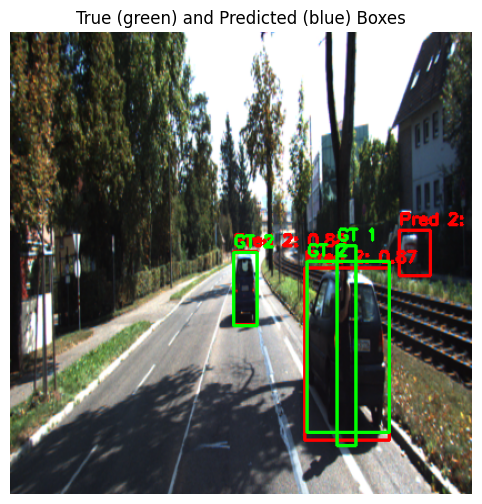

True Boxes:
[0, 2, 1, 201.84375, 198.40428161621094, 222.38584899902344, 264.0989990234375]
[0, 2, 1, 267.02044677734375, 206.91287231445312, 341.0630798339844, 360.8217468261719]
[0, 1, 1, 294.98150634765625, 192.29183959960938, 311.27655029296875, 372.0482177734375]

Predicted Boxes:
[0, 2, 0.877754807472229, 201.44419860839844, 197.66326904296875, 222.19056701660156, 263.7637634277344]
[0, 2, 0.8651126623153687, 265.5486145019531, 212.81466674804688, 341.6997985839844, 367.8106384277344]
[0, 2, 0.5950955748558044, 350.0317077636719, 178.17274475097656, 378.0557556152344, 219.96644592285156]

Loss value for this sample: 5.0075


In [9]:
debug_training_sample_extra(model=model, dataloader=train_dataloader, loss_fn=loss_fn, device=DEVICE, sample_index=2, batch_index=10)

In [10]:
do_test = True
if do_test:
    metric_map, test_loss=test_step(
        model=model,
        dataloader=test_dataloader,
        batch_size=BATCH_SIZE,
        loss_fn=loss_fn,
        device=DEVICE
    )

    print(f"mAP | AP {metric_map}")
    print(f"Test Loss: {test_loss}")

Quantas foram: 748
mAP | AP (0.19647371125635496, [0.0003469588700681925, 3.76506031898316e-05, 0.5890365242958069])
Test Loss: 7.433639714058409


In [13]:
i = 13

In [35]:
i

34

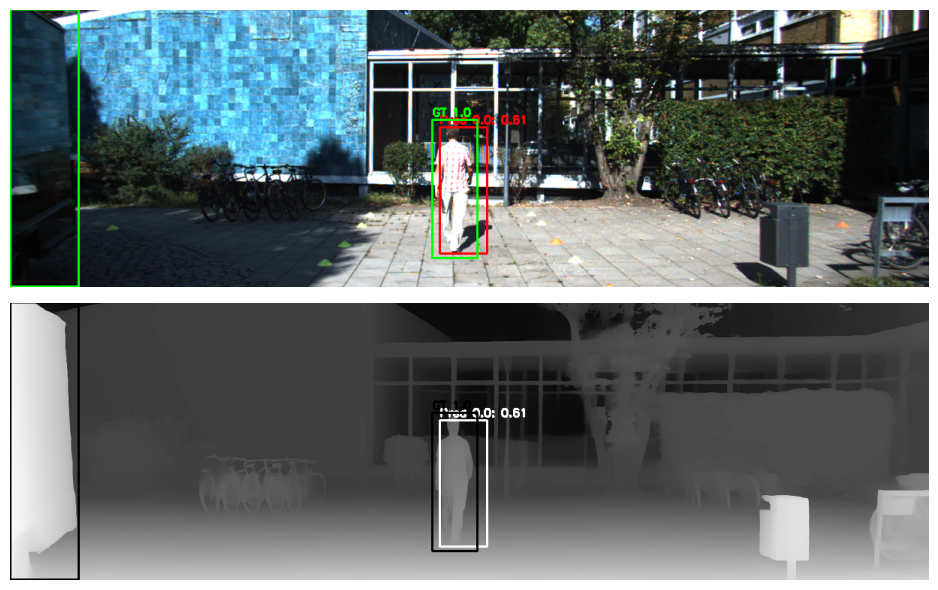

In [61]:
i += 1
plot_result(model=model, test_dataset=test_dataset, index=i)

In [115]:
from utils import draw_bounding_boxes
from PIL import Image
from glob import glob
import os 
i = -1

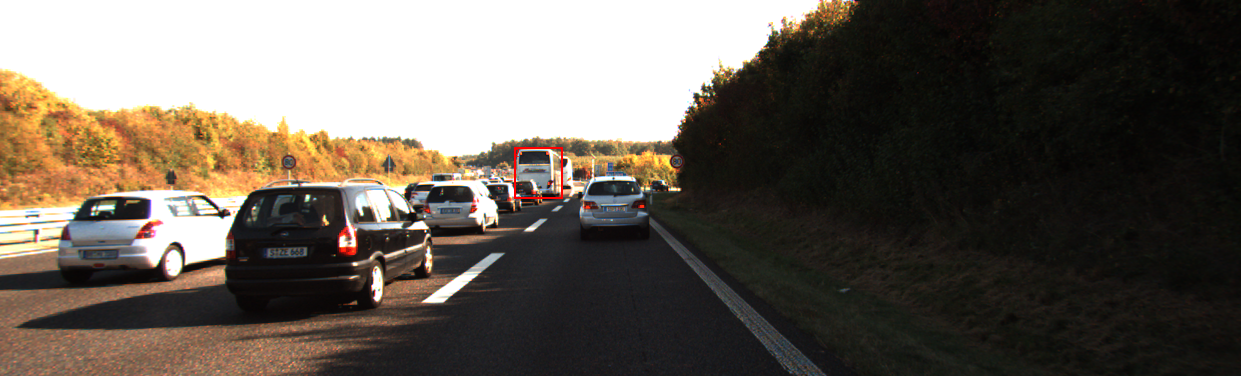

In [211]:

i += 1
labels = "/home/gkmo/workspace/data/KITTI_obj_detect_2d_kaggle/Downloads/only_misc"
label_files = sorted(glob(os.path.join(labels, "*.txt")))


label_i = label_files[i].split("/")[-1].split(".")[0]
test_list = glob(os.path.join(TEST_IMG_DIR, "*.png")) 
train_list = glob(os.path.join(TRAIN_IMG_DIR, "*.png")) 
val_list = glob(os.path.join(VAL_IMG_DIR, "*.png"))

label_path = "/home/gkmo/workspace/data/KITTI_obj_detect_2d_kaggle/Downloads/only_misc_converted"
label_file_i = label_path + f"/{label_i}.txt"

if os.path.exists(TRAIN_IMG_DIR + f"/{label_i}.png"):
    img = Image.open(TRAIN_IMG_DIR + f"/{label_i}.png")
if os.path.exists(TEST_IMG_DIR + f"/{label_i}.png"):
    img = Image.open(TEST_IMG_DIR + f"/{label_i}.png")
if os.path.exists(VAL_IMG_DIR + f"/{label_i}.png"):
    img = Image.open(VAL_IMG_DIR + f"/{label_i}.png")


draw_gt_boxes_on_image(img, label_file_i, class_names=["Cyclist", "Pedestrian", "2"])


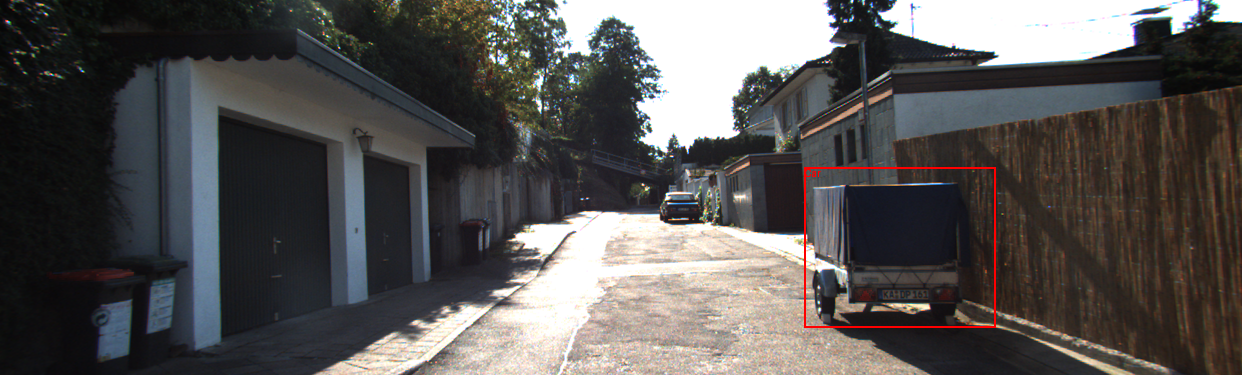